# CIP Deviations and its implications for Systemic Stress

Importing necessary libraries below

In [ ]:
!pip install arch # Install the arch package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model # Now you should be able to import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.kernel_regression import KernelReg
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

file_path_ForwardRateUSDtoEUR = '/content/drive/MyDrive/Colab Notebooks/ForwardRateUSDtoEUR.xlsx'
df_ForwardRateUSDtoEUR = pd.read_excel(file_path_ForwardRateUSDtoEUR, engine='openpyxl', header=1)
print(df_ForwardRateUSDtoEUR.head())

file_path_SpotRateUSDtoEUR = '/content/drive/MyDrive/Colab Notebooks/SpotRateUSDtoEUR.xlsx'
df_SpotRateUSDtoEUR = pd.read_excel(file_path_SpotRateUSDtoEUR, engine='openpyxl', header=1)
print(df_SpotRateUSDtoEUR.head())

file_path_USDTreasuryRate = '/content/drive/MyDrive/Colab Notebooks/USDTreasuryRate.xlsx'
df_USDTreasuryRate = pd.read_excel(file_path_USDTreasuryRate, engine='openpyxl', header=1)
print(df_USDTreasuryRate.head())

file_path_EUROBIR = '/content/drive/MyDrive/Colab Notebooks/EUROBIR.xlsx'
df_EUROBIR = pd.read_excel(file_path_EUROBIR, engine='openpyxl', header=1)
print(df_EUROBIR.head())



Mounted at /content/drive
         Date  ForwardRateUSDtoEUR
0  2025-03-25               0.9213
1  2025-03-19               0.9171
2  2025-03-18               0.9136
3  2025-03-17               0.9153
4  2025-03-14               0.9189
         Date SpotRateUSDtoEUR
0  1999-01-04         0.846597
1  1999-01-05          0.85034
2  1999-01-06         0.859402
3  1999-01-07         0.856751
4  1999-01-08         0.865501
         Date  USDTreasuryRate
0  1954-01-04             1.33
1  1954-01-05             1.28
2  1954-01-06             1.28
3  1954-01-07             1.31
4  1954-01-08             1.31
         Date  EUROBIR
0  1998-12-30    3.248
1  1998-12-31    3.244
2  1999-01-01    3.244
3  1999-01-04    3.234
4  1999-01-05    3.223


In [ ]:
#Ensure 'Date' is parsed as a datetime
for df in [df_ForwardRateUSDtoEUR, df_SpotRateUSDtoEUR, df_USDTreasuryRate, df_EUROBIR]:
    df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
# Merge all on 'Date'
merged = df_ForwardRateUSDtoEUR.merge(df_SpotRateUSDtoEUR, on='Date') \
               .merge(df_USDTreasuryRate, on='Date') \
               .merge(df_EUROBIR, on='Date')

# Preview result
print(merged.head())

        Date  ForwardRateUSDtoEUR SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR
0 2020-04-06               0.9264         0.925241             0.15   -0.318
1 2020-04-03               0.9251         0.926183             0.10   -0.341
2 2020-04-02               0.9208         0.920641             0.09   -0.336
3 2020-04-01               0.9119         0.914578             0.09   -0.343
4 2020-03-31               0.9064         0.907771             0.11   -0.363


In [ ]:
#Ensuring all variables are numeric
merged["ForwardRateUSDtoEUR"] = pd.to_numeric(merged["ForwardRateUSDtoEUR"], errors="coerce")
merged["SpotRateUSDtoEUR"] = pd.to_numeric(merged["SpotRateUSDtoEUR"], errors="coerce")
merged["USDTreasuryRate"] = pd.to_numeric(merged["USDTreasuryRate"], errors="coerce")
merged["EUROBIR"] = pd.to_numeric(merged["EUROBIR"], errors="coerce")


In [ ]:
# Check for invalid (non-positive) values before applying log
merged = merged[(merged["ForwardRateUSDtoEUR"] > 0) & (merged["SpotRateUSDtoEUR"] > 0)]

In [ ]:
#Calculating CIP deviation according to Hernandez
merged["rho"] = np.log(merged["ForwardRateUSDtoEUR"]) - np.log(merged["SpotRateUSDtoEUR"])
merged["x"] = merged["USDTreasuryRate"] - merged["EUROBIR"] - merged["rho"]

<ipython-input-12-873976b1b370>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["rho"] = np.log(merged["ForwardRateUSDtoEUR"]) - np.log(merged["SpotRateUSDtoEUR"])
<ipython-input-12-873976b1b370>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["x"] = merged["USDTreasuryRate"] - merged["EUROBIR"] - merged["rho"]


In [ ]:
#saving data file with cip deviation, forward rate, spote rate, interest rates USD, EUR
merged.to_csv('merged.csv', index=False)

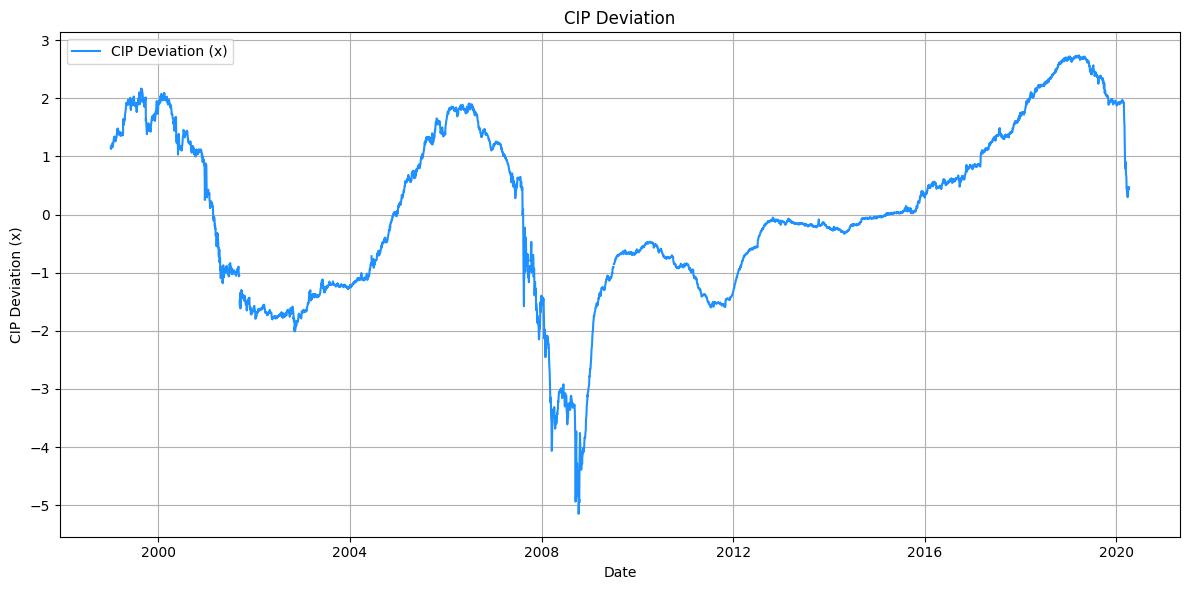

<Figure size 640x480 with 0 Axes>

In [ ]:
#Creating graph for cip deviation over the years
merged = merged.sort_values("Date")
plt.figure(figsize=(12, 6))
plt.plot(merged["Date"], merged["x"], label="CIP Deviation (x)", color="dodgerblue")
plt.title("CIP Deviation")
plt.xlabel("Date")
plt.ylabel("CIP Deviation (x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("CIP Deviation.png")

In [ ]:
#Generating inputs for CISS through reverse engineering from CISS measure provided by ECB

weights = {
    "Bond": 0.20,
    "Equity": 0.35,
    "Intermediaries": 0.30,
    "FX": 0.15
}
ROLLING_WINDOW = 52
labels = list(weights.keys())
weight_vec = np.array([weights[l] for l in labels])
# === 1. LOAD CONTRIBUTIONS FROM .XLSX FILES ===
def load_contrib_excel(file, name, weight):
    df = pd.read_excel(file, engine="openpyxl", header=1)
    df.columns = [col.strip() for col in df.columns]

    # Detect and rename 'Date' column
    if "Date" not in df.columns:
        if "TIME PERIOD" in df.columns:
            df.rename(columns={"TIME PERIOD": "Date"}, inplace=True)
        else:
            raise ValueError(f"No date column found in {file}")

    # Parse date
    df["Date"] = pd.to_datetime(df["Date"])

    # Rename contribution column (we expect it to be named like 'Bond', 'Equity', etc.)
    df.rename(columns={name: f"{name}_Contrib"}, inplace=True)

    # Convert to numeric (handles any stray text or symbols)
    df[f"{name}_Contrib"] = pd.to_numeric(df[f"{name}_Contrib"], errors="coerce")

    # Invert contribution to estimate subindex using sqrt(contribution / weight²)
    df[f"{name}_Input"] = np.sqrt((df[f"{name}_Contrib"] / df[f"{name}_Contrib"].sum()) / (weight ** 2))

    # Return cleaned columns
    return df[["Date", f"{name}_Input"]]

# Load all contribution files
bond = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/bond.xlsx", "Bond", weights["Bond"])
equity = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/equity.xlsx", "Equity", weights["Equity"])
intermediaries = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/intermediaries.xlsx", "Intermediaries", weights["Intermediaries"])
fx = load_contrib_excel("/content/drive/MyDrive/Colab Notebooks/fx.xlsx", "FX", weights["FX"])

# Merge subindices
sub_df = bond.merge(equity, on="Date") \
             .merge(intermediaries, on="Date") \
             .merge(fx, on="Date")
sub_df.set_index("Date", inplace=True)

# === 2. CALCULATE ROLLING CISS & SAVE CORRELATIONS ===
ciss_vals = []
ciss_dates = []
corr_records = []

for t in range(ROLLING_WINDOW, len(sub_df)):
    s_t = sub_df.iloc[t].values
    C_t = sub_df.iloc[t - ROLLING_WINDOW:t].corr().values
    y_t = weight_vec * s_t
    ciss_val = np.dot(y_t, np.dot(C_t, y_t))
    ciss_vals.append(ciss_val)
    ciss_dates.append(sub_df.index[t])

    # Save correlation matrix (flattened)
    corr_record = {"Date": sub_df.index[t]}
    for i in range(4):
        for j in range(4):
            corr_record[f"{labels[i]}_{labels[j]}"] = C_t[i, j]
    corr_records.append(corr_record)

# === 3. BUILD AND SAVE OUTPUTS ===
# CISS series
df_ciss = pd.DataFrame({
    "Date": ciss_dates,
    "Reconstructed_CISS": ciss_vals
}).set_index("Date")
df_ciss.to_csv("reconstructed_ciss.csv")
reconstructed_ciss = pd.read_csv("reconstructed_ciss.csv")
print(df_ciss.head())

# Inverted subindices
sub_df.to_csv("inverted_subindices.csv")
inverted_subindices = pd.read_csv("inverted_subindices.csv")
print(sub_df.head())

# Correlation matrices
corr_df = pd.DataFrame(corr_records)
corr_df.to_csv("reconstructed_correlation_matrices.csv", index=False)
print(corr_df.head())

print("Saved: reconstructed_ciss.csv, inverted_subindices.csv, reconstructed_correlation_matrices.csv")




            Reconstructed_CISS
Date                          
2000-01-07            0.010502
2000-01-14            0.008801
2000-01-21            0.006477
2000-01-28            0.009096
2000-02-04            0.009530
            Bond_Input  Equity_Input  Intermediaries_Input  FX_Input
Date                                                                
1999-01-08    0.126590      0.074978              0.059447  0.238206
1999-01-15    0.153859      0.095726              0.094363  0.259037
1999-01-22    0.133017      0.092553              0.093154  0.189201
1999-01-29    0.107428      0.083534              0.084980  0.164433
1999-02-05    0.135220      0.088199              0.087525  0.208906
        Date  Bond_Bond  Bond_Equity  Bond_Intermediaries   Bond_FX  \
0 2000-01-07        1.0     0.601876             0.608498  0.618682   
1 2000-01-14        1.0     0.616979             0.621044  0.652728   
2 2000-01-21        1.0     0.592424             0.608435  0.638749   
3 2000-01-28    

ECB Columns: ['Date', 'TIME PERIOD', 'ECB_CISS']
Merged CISS shape: (1319, 3)
   Unnamed: 0        Date  Reconstructed_CISS  ECB_CISS  Normalized_CISS
0           0  2000-01-07            0.010502    0.1041         0.382659
1           1  2000-01-14            0.008801    0.0772         0.320697
2           2  2000-01-21            0.006477    0.0561         0.236004
3           3  2000-01-28            0.009096    0.0921         0.331418
4           4  2000-02-04            0.009530    0.0841         0.347237


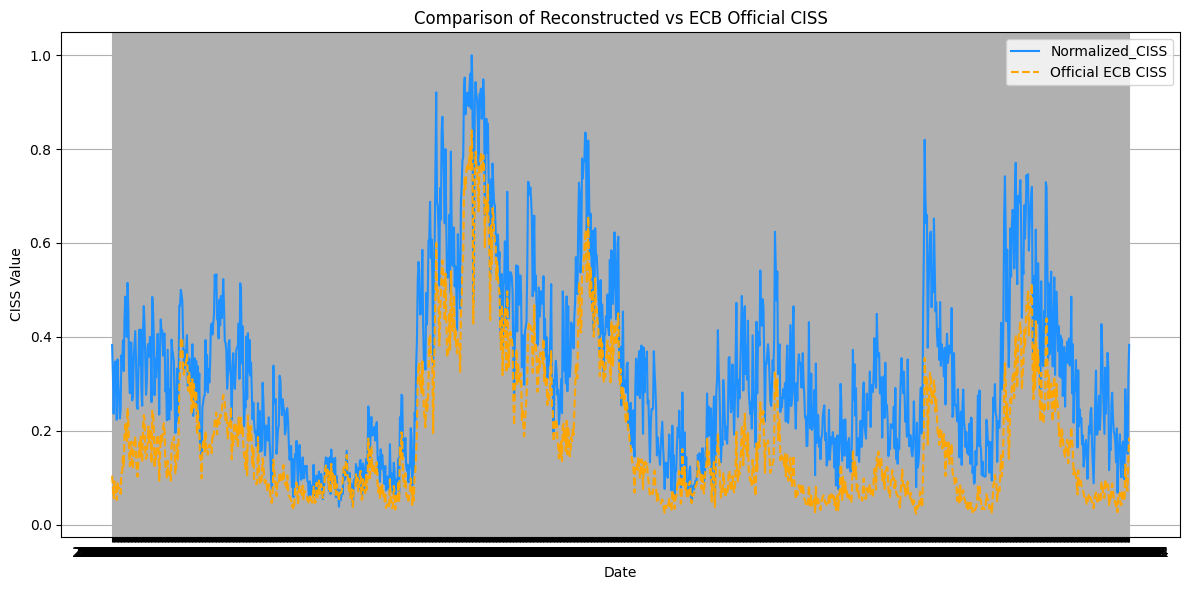

In [ ]:
#Plotting Offical ECB CISS againt CISS calculated by reverse engineering in the previous code block

# Load ECB official CISS
ecb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/ecb_ciss.xlsx", engine="openpyxl", header=1)

# Make sure 'Date' and 'CISS' columns exist and are clean
print("ECB Columns:", ecb.columns.tolist())  # Debug line

# Convert date column
ecb["Date"] = pd.to_datetime(ecb["Date"])

# Reset index of reconstructed CISS
df_ciss_reset = df_ciss.reset_index()

# Merge on 'Date'
combined = df_ciss_reset.merge(ecb[["Date", "ECB_CISS"]], on="Date", how="inner")

# Optional: Check how many rows were matched
print(f"Merged CISS shape: {combined.shape}")
# Normalize to [0, 1] based on max
combined['Normalized_CISS'] = combined['Reconstructed_CISS'] / combined['Reconstructed_CISS'].max()
combined.to_csv("combined.csv")
combined = pd.read_csv("combined.csv")
print(combined.head())

plt.figure(figsize=(12, 6))
plt.plot(combined["Date"], combined["Normalized_CISS"], label="Normalized_CISS", color="dodgerblue")
plt.plot(combined["Date"], combined["ECB_CISS"], label="Official ECB CISS", linestyle="--", color="orange")

plt.title("Comparison of Reconstructed vs ECB Official CISS")
plt.xlabel("Date")
plt.ylabel("CISS Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("CISS_Comparison.png")
plt.show()

In [ ]:
#Creating a single data file now and calling it 'data'

merged['Date'] = pd.to_datetime(merged['Date'])
inverted_subindices['Date'] = pd.to_datetime(inverted_subindices['Date'])
reconstructed_ciss['Date'] = pd.to_datetime(reconstructed_ciss['Date'])
combined['Date'] = pd.to_datetime(combined['Date'])
data = merged.merge(inverted_subindices, on='Date') \
               .merge(reconstructed_ciss, on='Date') \
               .merge(combined, on='Date')
data = data.dropna().copy()
print(data.head())

        Date  ForwardRateUSDtoEUR  SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR  \
0 2000-01-07               0.9717          0.971440             5.22    3.322   
1 2000-01-14               0.9874          0.987362             5.25    3.320   
2 2000-01-21               0.9909          0.990099             5.31    3.310   
3 2000-01-28               1.0259          1.024066             5.48    3.486   
4 2000-02-04               1.0170          1.024590             5.50    3.492   

        rho         x  Bond_Input  Equity_Input  Intermediaries_Input  \
0  0.000268  1.897732    0.150432      0.088676              0.087357   
1  0.000039  1.929961    0.147397      0.072355              0.080741   
2  0.000809  1.999191    0.133929      0.061772              0.074423   
3  0.001790  1.992210    0.146688      0.070386              0.081643   
4 -0.007436  2.015436    0.145975      0.068923              0.083853   

   FX_Input  Reconstructed_CISS_x  Unnamed: 0  Reconstructed_CISS_y  ECB_C

In [ ]:
#Preparation of data using Principal Component Analysis

# Create lag features
for lag in [1]:
    data[f"x_lag_{lag}"] = data["x"].shift(lag)
data = data.dropna()
# PCA on input features
feature_cols = ["x_lag_1", "Bond_Input", "Equity_Input", "FX_Input", "Intermediaries_Input"]
X_raw = data[feature_cols].values
y = data["x"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)




Explained variance ratio: [0.72630102 0.14093729]
        Date  ForwardRateUSDtoEUR  SpotRateUSDtoEUR  USDTreasuryRate  EUROBIR  \
2 2000-01-21               0.9909          0.990099             5.31    3.310   
3 2000-01-28               1.0259          1.024066             5.48    3.486   
4 2000-02-04               1.0170          1.024590             5.50    3.492   
5 2000-02-11               1.0133          1.015538             5.49    3.490   
6 2000-02-18               1.0137          1.015228             5.58    3.531   

        rho         x  Bond_Input  Equity_Input  Intermediaries_Input  \
2  0.000809  1.999191    0.133929      0.061772              0.074423   
3  0.001790  1.992210    0.146688      0.070386              0.081643   
4 -0.007436  2.015436    0.145975      0.068923              0.083853   
5 -0.002206  2.002206    0.139273      0.063566              0.077458   
6 -0.001507  2.050507    0.118506      0.062675              0.073333   

   FX_Input  Reconstruct

In [ ]:
#Kernel weighted Quantile Regression for estimating the 'neutral band', and calculating CIP stress measure

def gaussian_kernel(dist, h):
    return np.exp(-0.5 * (dist / h)**2)

def kernel_quantile_estimate(X_train, y_train, X_pred, tau, h, kernel_func):
    dists = cdist(X_pred, X_train)
    weights = kernel_func(dists, h)
    quantiles = []
    for i in range(weights.shape[0]):
        w = weights[i]
        if np.all(w == 0) or np.isnan(w).any():
            quantiles.append(np.nan)
            continue
        sorted_idx = np.argsort(y_train)
        y_sorted = y_train[sorted_idx]
        w_sorted = w[sorted_idx]
        w_cumsum = np.cumsum(w_sorted)
        if w_cumsum[-1] == 0:
            quantiles.append(np.nan)
            continue
        w_cumsum /= w_cumsum[-1]
        idx = np.searchsorted(w_cumsum, tau)
        q_value = y_sorted[min(idx, len(y_sorted) - 1)]
        quantiles.append(float(q_value))
    return np.array(quantiles)

taus = [0.05, 0.95]
for tau in taus:
    print(f"Estimating τ = {tau}")
    h_opt = 2.5  # Preset optimal bandwidth
    data[f"Q{tau*100:.1f}"] = kernel_quantile_estimate(X_pca, y, X_pca, tau, h_opt, gaussian_kernel)

#Compute stress & neutral band
data["Band_Width"] = data["Q95.0"] - data["Q5.0"]

eps = 1e-6
data["CIP_Stress"] = np.where(
    (y < (data["Q5.0"] - eps)) | (y > (data["Q95.0"] + eps)),
    np.maximum(np.abs(y - data["Q5.0"]), np.abs(y - data["Q95.0"])),
    0
)
data["CIP_Stress_Log"] = data["CIP_Stress"].apply(lambda x: np.log1p(x))

#Save file with results
data.to_csv("data_withresults.csv", index=False)
data_withresults = pd.read_csv("data_withresults.csv")
print(data_withresults.head())

Estimating τ = 0.05
Estimating τ = 0.95
         Date  ForwardRateUSDtoEUR  SpotRateUSDtoEUR  USDTreasuryRate  \
0  2000-01-21               0.9909          0.990099             5.31   
1  2000-01-28               1.0259          1.024066             5.48   
2  2000-02-04               1.0170          1.024590             5.50   
3  2000-02-11               1.0133          1.015538             5.49   
4  2000-02-18               1.0137          1.015228             5.58   

   EUROBIR       rho         x  Bond_Input  Equity_Input  \
0    3.310  0.000809  1.999191    0.133929      0.061772   
1    3.486  0.001790  1.992210    0.146688      0.070386   
2    3.492 -0.007436  2.015436    0.145975      0.068923   
3    3.490 -0.002206  2.002206    0.139273      0.063566   
4    3.531 -0.001507  2.050507    0.118506      0.062675   

   Intermediaries_Input  ...  Unnamed: 0  Reconstructed_CISS_y  ECB_CISS  \
0              0.074423  ...           2              0.006477    0.0561   
1       

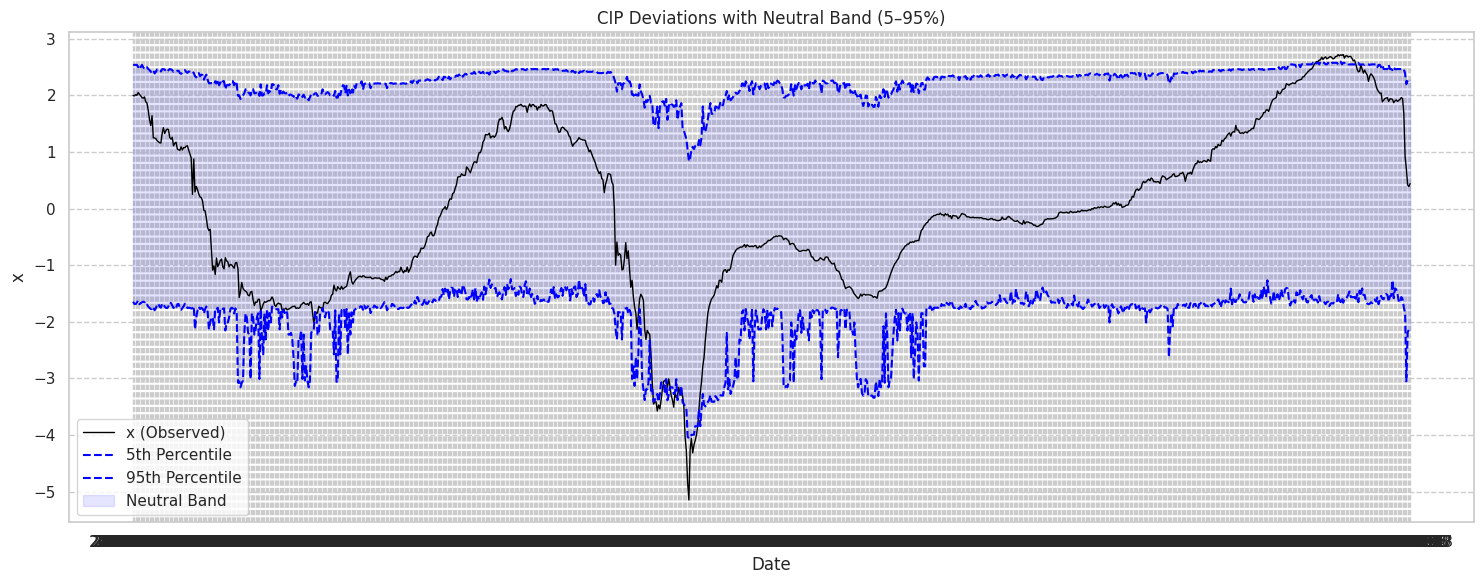

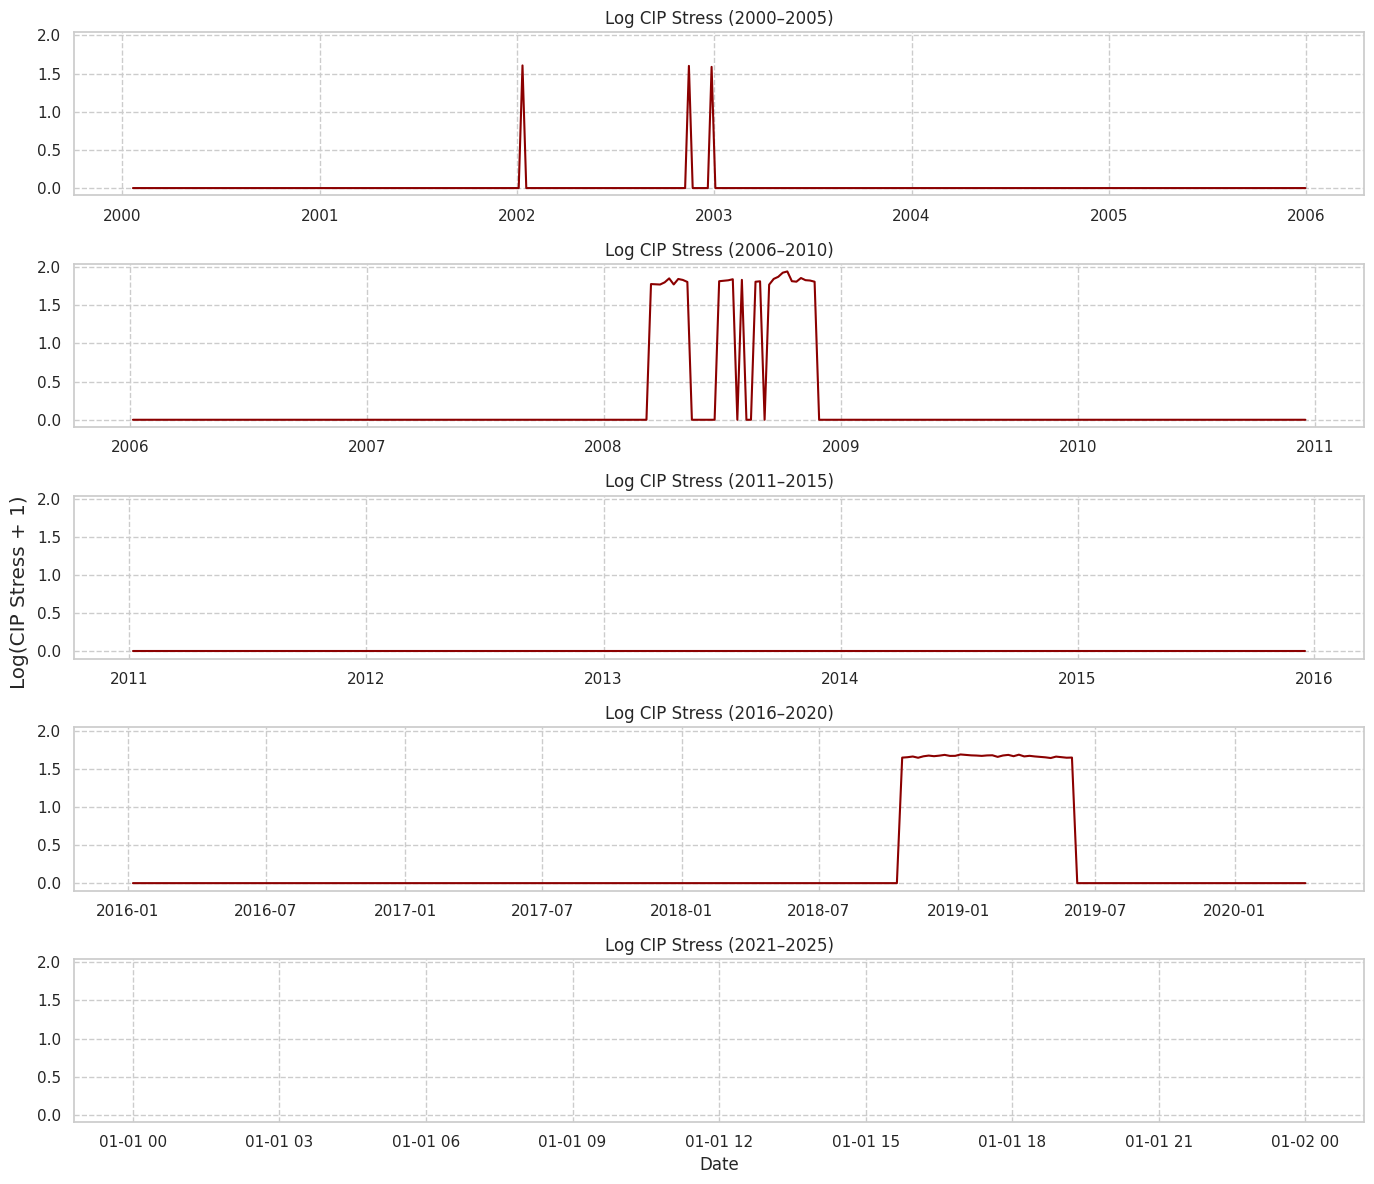

In [ ]:
#Plots
#Plot the neutral band with original x
plt.figure(figsize=(15, 6))
plt.plot(data_withresults["Date"], data_withresults["x"], label="x (Observed)", color="black", linewidth=1)
plt.plot(data_withresults["Date"], data_withresults["Q5.0"], label="5th Percentile", linestyle="--", color="blue")
plt.plot(data_withresults["Date"], data_withresults["Q95.0"], label="95th Percentile", linestyle="--", color="blue")
plt.fill_between(data_withresults["Date"], data_withresults["Q5.0"], data_withresults["Q95.0"], color='blue', alpha=0.1, label="Neutral Band")
plt.title("CIP Deviations with Neutral Band (5–95%)")
plt.xlabel("Date")
plt.ylabel("x")
plt.legend()
plt.grid(True, linestyle="--")
plt.tight_layout()
plt.savefig("Neutral_Band_Full.png", dpi=300, transparent=True)
plt.show()

#Faceted log stress plots
sns.set(style="whitegrid")
year_bins = [(2000, 2005), (2006, 2010), (2011, 2015), (2016, 2020), (2021, 2025)]
fig, axes = plt.subplots(len(year_bins), 1, figsize=(14, 12), sharey=True)

for i, (start, end) in enumerate(year_bins):
    ax = axes[i]
    data_withresults["Date"] = pd.to_datetime(data_withresults["Date"])
    mask = (data_withresults["Date"].dt.year >= start) & (data_withresults["Date"].dt.year <= end)
    ax.plot(data_withresults["Date"][mask], data_withresults["CIP_Stress_Log"][mask], color="darkred", linewidth=1.5)
    ax.set_title(f"Log CIP Stress ({start}–{end})", fontsize=12)
    ax.grid(True, linestyle="--")

axes[-1].set_xlabel("Date")
fig.supylabel("Log(CIP Stress + 1)")
plt.tight_layout()
plt.savefig("CIP_Stress_Log_Faceted.png", dpi=300, transparent=True)
plt.show()

In [ ]:
# Level Regression
import statsmodels.api as sm
df_reg = pd.read_csv("data_withresults.csv", parse_dates=["Date"])
X_vars = ["Band_Width", "Bond_Input", "Equity_Input", "FX_Input", "Intermediaries_Input"]
X = df_reg[X_vars]
X = sm.add_constant(X)  # Adds intercept
y = df_reg["ECB_CISS"]

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ECB_CISS   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     735.2
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        11:27:20   Log-Likelihood:                 1172.8
No. Observations:                1012   AIC:                            -2334.
Df Residuals:                    1006   BIC:                            -2304.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8084 